# Connect to Railway from Notebook



## Import Libraries

In [26]:
import os
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv
from datetime import datetime



# Import data

In [44]:
ft_btc_articles_df = pd.read_csv("ft_btc.csv")
api_btc_df = pd.read_csv("alphavantage_api_btc.csv")

In [45]:
# dropping extra columns
api_btc_df = api_btc_df.drop(columns="Unnamed: 0")
ft_btc_articles_df = ft_btc_articles_df.drop(columns="Unnamed: 0")

In [46]:
# casting datecolumns to date time type
ft_btc_articles_df["date"] = pd.to_datetime(ft_btc_articles_df["date"], dayfirst=True)
# ft_btc_df['date_formatted'] = ft_btc_df['date'].dt.strftime('%d-%m-%Y')
api_btc_df["date"] =  pd.to_datetime(api_btc_df["date"])

## Create Connection

In [61]:
load_dotenv()
dbconn = os.getenv("DBCONN")

In [ ]:
#connectino string
connection_string = dbconn

# Create SQLAlchemy engine
engine = create_engine(connection_string)


## Creating SQL Tables

In [84]:
from sqlalchemy import text

def create_table():
    with engine.connect() as conn:
        conn.execute(text("""
            CREATE TABLE IF NOT EXISTS ft_articles (
                id SERIAL PRIMARY KEY,
                title TEXT,
                link TEXT,
                snippet TEXT,
                date DATE
            );
            CREATE TABLE IF NOT EXISTS api_data (
                date DATE PRIMARY KEY,
                open FLOAT,
                high FLOAT,
                low FLOAT,
                volume FLOAT
            );
        """))

create_table()

## Store DFs

In [85]:
# populating articles table
ft_btc_articles_df.to_sql("ft_articles", con=engine, if_exists="append", index = False)
# populating api data table
api_btc_df.to_sql("api_data", con=engine, if_exists="append", index = False)


350

## Double checking data types

In [86]:
query ="""
SELECT column_name, data_type 
FROM information_schema.columns 
WHERE table_name = 'ft_articles';

"""
pd.read_sql(query, con=engine)

,column_name,data_type
0,date,timestamp without time zone
1,title,text
2,link,text
3,snippet,text


In [ ]:
query ="""
SELECT column_name, data_type 
FROM information_schema.columns 
WHERE table_name = 'api_data';
"""
pd.read_sql(query, con=engine)

,column_name,data_type
0,date,timestamp without time zone
1,open,double precision
2,high,double precision
3,low,double precision
4,close,double precision
5,volume,double precision


## Data insertion

In [ ]:
# insert a single row

def insert_article(engine, title, link, snippet, date):
    query = text("""
        INSERT INTO ft_articles (title, link, snippet, date)
        VALUES (:title, :link, :snippet, :date) # 
    """)
    # :xxx  = placeholders. They’ll be replaced with real values later when the query is executed.
    with engine.connect() as conn:
        conn.execute(query,{
            "title": title,
            "link": link,
            "snippet": snippet,
            "date": date
        })
        print("✅ Inserted 1 article.")

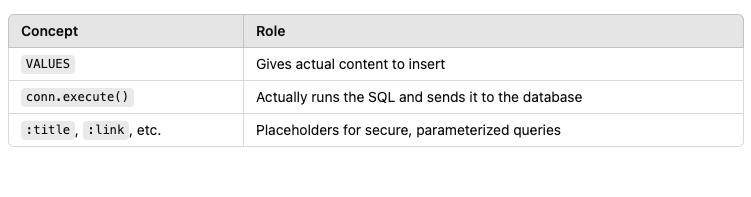

In [ ]:
# example

# insert_article(
#     engine,
#     title="Bitcoin rebounds again",
#     link="https://www.ft.com/content/example",
#     snippet="The cryptocurrency is back in the green...",
#     date="2025-03-26"
# )

engine.connect vs engine.begin
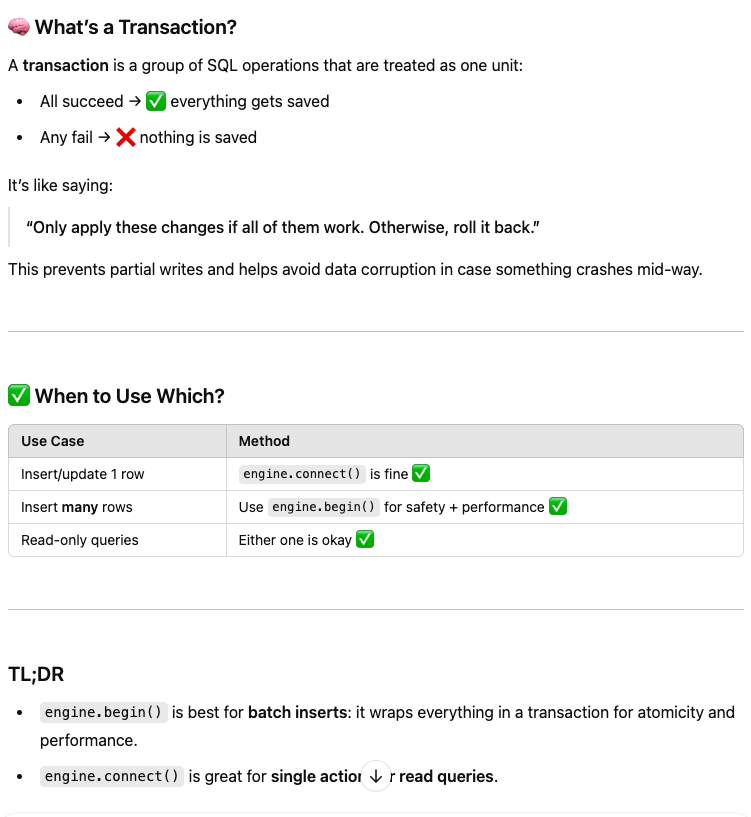